# Inpainting et LASSO

Data Type: uint8
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(248, 342, 3)


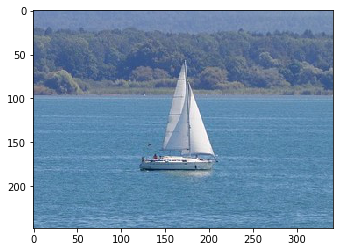

In [1]:
#Lecture d'image
from PIL import Image
import matplotlib.colors as mcolors
import random
import copy
from sklearn import linear_model
from arftools import *
import numpy as np
from numpy import linalg as LA
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import cm

filename = 'mer2_rogn.jpg'
def read_im(fn):
    pixels = plt.imread(fn)
    # Normalize between 0 and 1
    # confirm pixel range
    print('Data Type: %s' % pixels.dtype)
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

    # convert from integers to floats
    pixels = pixels.astype('float32')
    # normalize to the range 0-1
    pixels /= 255.0
    # confirm the normalization
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
    
    # Convert to HSV
    pixels = mcolors.rgb_to_hsv(pixels)
    
    return pixels

def plot_img(img):
    plt.imshow(mcolors.hsv_to_rgb(img))

def get_patch(i,j,h,img):
    #import ipdb; ipdb.set_trace()
    return img[int(i-(h-1)/2):int(i+(h-1)/2),int(j-(h-1)/2):int(j+(h-1)/2)]

def get_patch_boundaries(i,j,h):
    """
    retourne les indices de la bordure intérieure du patch de centre (i,j) et de taille h 
    """
    
    b1 = np.array([[u,int(j-(h-1)/2)] for u in range(int(i-(h-1)/2),int(i+(h-1)/2))])
    b2 = np.array([[u,int(j+(h-1)/2)-1] for u in range(int(i-(h-1)/2),int(i+(h-1)/2))])    
    b3 = np.array([[int(i-(h-1)/2),u] for u in range(int(j-(h-1)/2),int(j+(h-1)/2))])
    b4 = np.array([[int(i+(h-1)/2)-1,u] for u in range(int(j-(h-1)/2),int(j+(h-1)/2))])
    
    ind_pix = []
    for u in range(int(i-(h-1)/2),int(i+(h-1)/2)):
        for v in range(int(j-(h-1)/2),int(j+(h-1)/2)):
            ind_pix.append([u,v])
    
    border = np.concatenate((b1,b2,b3,b4)).T
    
    return border, np.array(ind_pix).T
    

def get_all_patchs(h, img, step):
    #return all patchs with length h
    n, m, d = img.shape
    patchs = []
    for i in range(int(h/2), int(n - h/2), step):
        for j in range(int(h/2), int(m - h/2), step):
            patchs.append(conv_patch(get_patch(i,j,h,img)))
    return patchs

def get_dict(h, img, step):
    #return all patchs with and without missing pixels
    patchs = get_all_patchs(h, img, step)
    dict_patchs = []
    noised_patchs = []
    for p in patchs:
        if -100 in set(p):
            noised_patchs.append(p)
        else:
            dict_patchs.append(p)
            
    return dict_patchs, noised_patchs


def aprox_patch(patch, dico, classi):
    
    expr_pixels_index = np.where(patch != -100)[0]
    
    Y = patch[expr_pixels_index]
    X = np.array(dico).T[expr_pixels_index,:]

    #import ipdb; ipdb.set_trace()
    classi.fit(X,Y)
    
    return clf.coef_

def reconstruc_patch(patch, coeffs, dico):
    
    reconstruct_patch = copy.deepcopy(patch)
    noised_pixels_index = np.where(patch == -100)[0]
    X = np.array(dico).T
    reconstruct_pixels = np.dot(X,coeffs)
    
    #import ipdb; ipdb.set_trace()
    for i in noised_pixels_index:
        reconstruct_patch[i] = reconstruct_pixels[i]
    return reconstruct_patch
    
    
    
def conv_patch(patch):
    #convert tensor to vect
    n, m, d = patch.shape
    p = patch.reshape((n**2)*3,1)
    return p.squeeze()

def plot_patch(patch, h):
    p = patch.reshape(h,h,3)
    plt.imshow(mcolors.hsv_to_rgb(p))


def noise(prc, img):
    # Fonction à optimiser !
    
    noised_img = copy.deepcopy(img)
    n, m, d = img.shape
    
    nb_pixel = n*m
    nb_pixel_suppr = int((prc/100)*nb_pixel)
    
    random_rows = [random.randint(0,n-1) for i in range(nb_pixel_suppr)]
    random_columns = [random.randint(0,m-1) for i in range(nb_pixel_suppr)]
    
    noised_img[random_rows, random_columns, :] = -100
   
    return noised_img


def delete_rect(img,i,j,height,width):
    #à optimiser
    n, m, d = img.shape
    n_img = copy.deepcopy(img)
    
    #On initialise les confiances des pixels lorsque la zone à restaurer est sélectionnée
    confidence = np.ones((n,m))
    
    n_img[max(0,int(i-(height-1)/2)):min(n,int(i+(height-1)/2)),max(0,int(j-(width-1)/2)):min(m,int(j+(width-1)/2)),:] = -100
    confidence[max(0,int(i-(height-1)/2)):min(n,int(i+(height-1)/2)),max(0,int(j-(width-1)/2)):min(m,int(j+(width-1)/2))] = 0

    #On initialise les frontières de la zone à restaurer (bordure extérieure)
    b1 = np.array([[u,max(0,int(j-(width-1)/2))-1] for u in range(max(0,int(i-(height-1)/2)),min(n,int(i+(height-1)/2)))])
    b2 = np.array([[u,min(m,int(j+(width-1)/2))] for u in range(max(0,int(i-(height-1)/2)),min(n,int(i+(height-1)/2)))])    
    b3 = np.array([[max(0,int(i-(height-1)/2))-1,u] for u in range(max(0,int(j-(width-1)/2)),min(m,int(j+(width-1)/2)))])
    b4 = np.array([[min(n,int(i+(height-1)/2)),u] for u in range(max(0,int(j-(width-1)/2)),min(m,int(j+(width-1)/2)))])
    
    border = np.concatenate((b1,b2,b3,b4)).T
    
    #test de la bordure
    #n_img[border[0], border[1]] = [0,1,1]
    
    return n_img, border, confidence


def update_bound(old_img, new_img, old_bound,i,j,h):
    """
    old_bound : matrice d'indices des pixels sur la bordure extérieure de l'image avant l'itération actuelle
    patch_bound : matrice d'indices des pixels sur la bordure intérieure du patch
    """
    patch_bound, patch_ind = get_patch_boundaries(i,j,h)
    x = np_intersect2D(old_bound.T, patch_ind) #On récupère les pixels du patch qui étaient sur la bordure
    
    x_hashable = map(tuple, x)
    pix_suppr = set(x_hashable)
    
    bound_hashable = map(tuple,old_bound.T)
    set_patch_bound = set(bound_hashable)
    
    set_new_bound = set_patch_bound.difference(pix_suppr)
    
    new_bound = np.array(list(set_new_bound))
    
    new_p = []
    
    for p in patch_bound.T:
        #import ipdb;ipdb.set_trace()
        if -100.0 in set(old_img[p[0],p[1]]) and -100.0 not in set(new_img[p[0],p[1]]):
            new_p.append(list(p))
            
    #mport ipdb;ipdb.set_trace()
    if len(np.array(new_p)) == 0:
        return new_bound
    else:
        return np.concatenate((new_bound,np.array(new_p)))



def priorities(border, conf_matr, h, img):
    max_c, max_p = -1, -1
    for p in border.T:
        patch = get_patch(p[0],p[1],h,img)
        patch_bound, patch_ind = get_patch_boundaries(p[0],p[1],h)
        #import ipdb; ipdb.set_trace()
        conf_p = np.sum(conf_matr[patch_ind[0], patch_ind[1]])/(patch.shape[0]*patch.shape[1])
        conf_matr[p[0], p[1]] = conf_p
        if conf_p > max_c:
            max_c = conf_p
            max_p = p
    
    return max_p, conf_matr


def np_intersect2D(A,B):
    
    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
       'formats':ncols * [A.dtype]}

    C = np.intersect1d(A.view(dtype), B.view(dtype))
    C = C.view(A.dtype).reshape(-1, ncols)
    return C


sea_img = read_im(filename)
plot_img(sea_img)
print(sea_img.shape)

## Noised img +  patch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

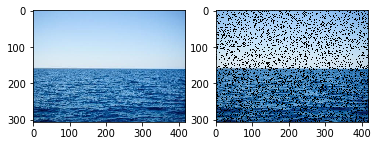

In [469]:
#patch centré en [150,200] de taille 30
patch = get_patch(150,200,30,sea_img)

#noised img
noised_img = noise(20,sea_img)

#noised patch centré en [150,200] de taille 30
noised_patch = get_patch(150,200,30,noised_img)


plt.figure()
f, axarr = plt.subplots(1,2) 

axarr[0].imshow(mcolors.hsv_to_rgb(sea_img))
axarr[1].imshow(mcolors.hsv_to_rgb(noised_img))

## Test de l'approximation de patch bruité

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

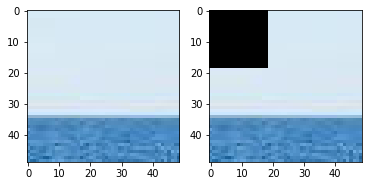

In [182]:
#We take a small part of the image to test the creation of the dict
length = 50
img_test = get_patch(150,200,length,sea_img)

cut_img_test = delete_rect(img_test,10,10,20,20)

plt.figure()
f, axarr = plt.subplots(1,2) 

axarr[0].imshow(mcolors.hsv_to_rgb(img_test))
axarr[1].imshow(mcolors.hsv_to_rgb(cut_img_test))

Dictionnaire se basant sur toute l'image (tous les patchs sont dans le dictionnaire)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


num of patchs of length 20: 841
--------------------------------
num of patchs in the dict: 841
num of noised patchs: 0


<Figure size 432x288 with 0 Axes>

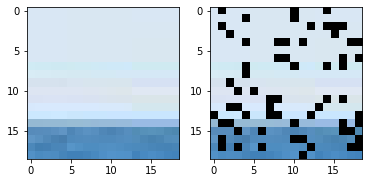

In [202]:
h = 20 #patch length
step = 1
all_patchs = get_all_patchs(h, img_test, step)
print(f"num of patchs of length 20: {len(all_patchs)}\n--------------------------------")
dict_patchs, noised_patchs = get_dict(h,img_test, step)
print(f"num of patchs in the dict: {len(dict_patchs)}\nnum of noised patchs: {len(noised_patchs)}")

#Construction du patch bruité de test
patch_test = get_patch(30,30,h,img_test)
noised_patch_test = noise(20,patch_test)

plt.figure()
f, axarr = plt.subplots(1,2) 

axarr[0].imshow(mcolors.hsv_to_rgb(patch_test))
axarr[1].imshow(mcolors.hsv_to_rgb(noised_patch_test))

Reconstruction du patch bruité

distance euclidienne entre le patch d'origine et le patch reconstitué : 0.01133192889392376


<Figure size 432x288 with 0 Axes>

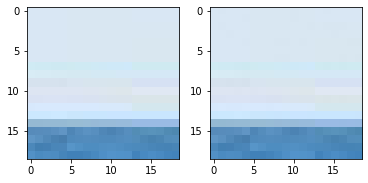

In [203]:
coeffs = aprox_patch(conv_patch(noised_patch_test), dict_patchs, a=0.00001)
new_patch = reconstruc_patch(conv_patch(noised_patch_test), coeffs, dict_patchs)

plt.figure()
f, axarr = plt.subplots(1,2) 

axarr[0].imshow(mcolors.hsv_to_rgb(patch_test))
axarr[1].imshow(mcolors.hsv_to_rgb(new_patch.reshape(19,19,3)))

print(f"distance euclidienne entre le patch d'origine et le patch reconstitué : {LA.norm(patch_test-new_patch.reshape(19,19,3))}")

# Exemple de reconstitution d'une image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(157, 250, 3)

<Figure size 432x288 with 0 Axes>

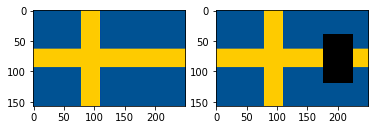

In [6]:
filename2 = "sweden.png"
p = plt.imread(filename2)
swe_img = mcolors.rgb_to_hsv(p)

n_swe_img, border, conf = delete_rect(swe_img,80,200,80,50)

plt.figure()
f, axarr = plt.subplots(1,2) 

axarr[0].imshow(mcolors.hsv_to_rgb(swe_img))
axarr[1].imshow(mcolors.hsv_to_rgb(n_swe_img))
n_swe_img.shape

Création du dictionnaire de patch : 

In [7]:
h = 40 #patch length
step = 1
all_patchs = get_all_patchs(h, n_swe_img, step)
print(f"num of patchs of length 20: {len(all_patchs)}\n--------------------------------")
dict_patchs, noised_patchs = get_dict(h,n_swe_img, step)
print(f"num of patchs in the dict: {len(dict_patchs)}\nnum of noised patchs: {len(noised_patchs)}")

num of patchs of length 20: 24570
--------------------------------
num of patchs in the dict: 16175
num of noised patchs: 8395


Selection du patch à restaurer (on prend ici un pixel au hasard sur la bordure)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 95 174]


<Figure size 432x288 with 0 Axes>

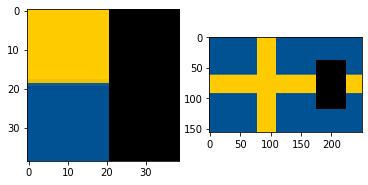

In [8]:
pixel = border.T[55]
print(pixel)
patch = get_patch(pixel[0],pixel[1],h,n_swe_img)
patch_bound, patch_ind = get_patch_boundaries(pixel[0],pixel[1],h)

plt.figure()
f, axarr = plt.subplots(1,2) 

axarr[0].imshow(mcolors.hsv_to_rgb(patch))
axarr[1].imshow(mcolors.hsv_to_rgb(n_swe_img))

Reconstruction du patch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


distance euclidienne entre le patch d'origine et le patch reconstitué : 4621.44580078125


<Figure size 432x288 with 0 Axes>

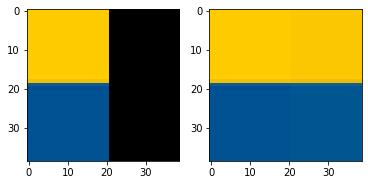

In [9]:
a = 0.001

clf = linear_model.Lasso(alpha=a, max_iter = 10000, normalize = False, positive = False, warm_start = False)
coeffs = aprox_patch(conv_patch(patch), dict_patchs,clf)
new_patch = reconstruc_patch(conv_patch(patch), coeffs, dict_patchs)

plt.figure()
f, axarr = plt.subplots(1,2) 

axarr[0].imshow(mcolors.hsv_to_rgb(patch))
axarr[1].imshow(mcolors.hsv_to_rgb(new_patch.reshape(patch.shape[0],patch.shape[0],3)))

print(f"distance euclidienne entre le patch d'origine et le patch reconstitué : {LA.norm(patch-new_patch.reshape(patch.shape[0],patch.shape[0],3))}")

Ajout du patch reconstruit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

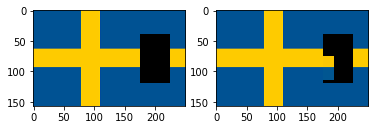

In [11]:
n_swe_img2 = copy.deepcopy(n_swe_img)
n_swe_img2[patch_ind[0], patch_ind[1]] = new_patch.reshape(patch.shape[0]**2,3)

plt.figure()
f, axarr = plt.subplots(1,2) 

axarr[0].imshow(mcolors.hsv_to_rgb(n_swe_img))
axarr[1].imshow(mcolors.hsv_to_rgb(n_swe_img2))

Mise à jour de la frontière

In [12]:
new_bound = update_bound(n_swe_img, n_swe_img2, border, pixel[0], pixel[1], h)

C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead


# Preparation de l'image et de la zone à restaurer

Data Type: uint8
Min: 0.000, Max: 252.000
Min: 0.000, Max: 0.988


(160, 284, 3)

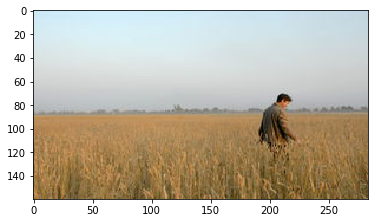

In [9]:
filename = "personne_champs.jpg"
p = read_im(filename)
plt.imshow(mcolors.hsv_to_rgb(p))
p.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


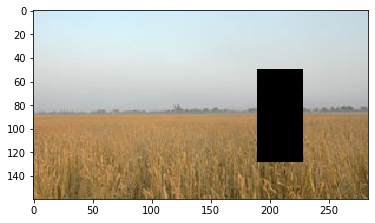

In [12]:
boat_img, border, conf = delete_rect(p,90,210,80,40)
plt.imshow(mcolors.hsv_to_rgb(boat_img))

# Algorithme d'Inpainting

Data Type: uint8
Min: 0.000, Max: 252.000
Min: 0.000, Max: 0.988


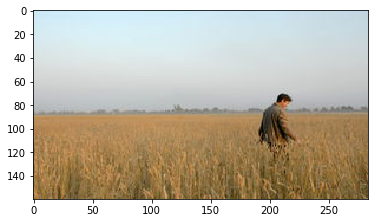

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


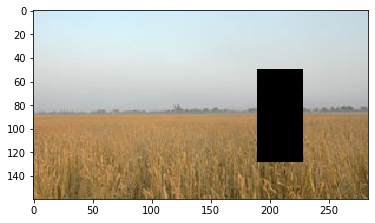

num of patchs of length 27: 34181
--------------------------------
num of patchs in the dict: 27525
num of noised patchs: 6656

itération 0


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


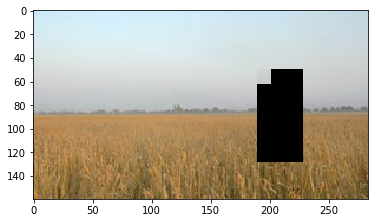


itération 1


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


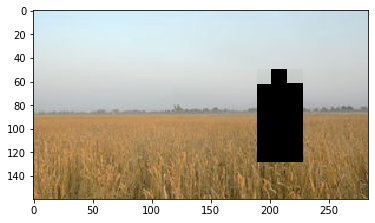


itération 2


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


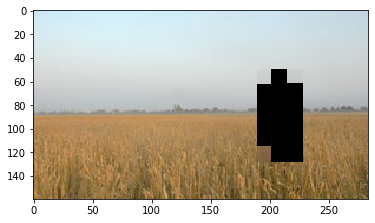


itération 3


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


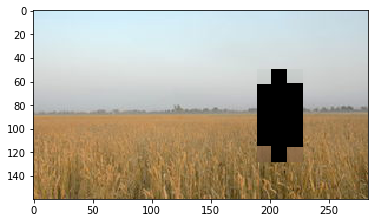


itération 4


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


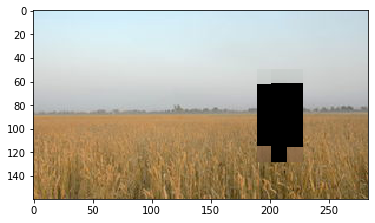


itération 5


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


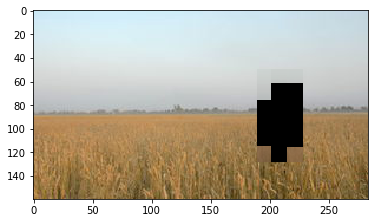


itération 6


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


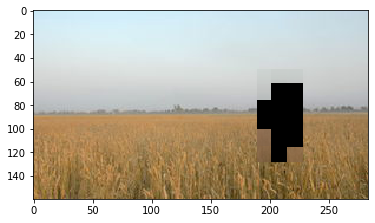


itération 7


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


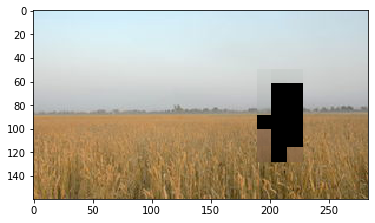


itération 8


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


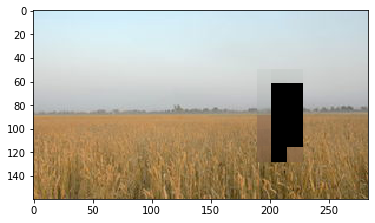


itération 9


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


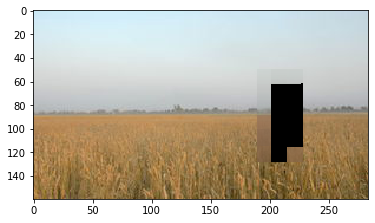


itération 10


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


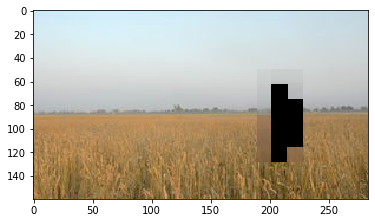


itération 11


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


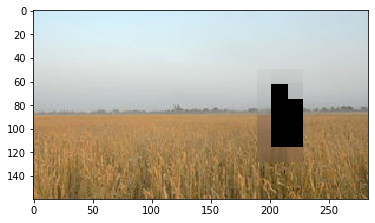


itération 12


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


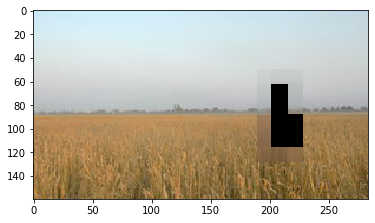


itération 13


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


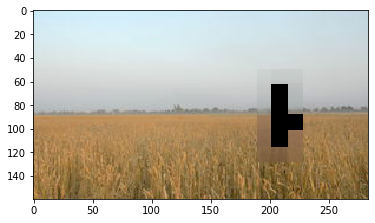


itération 14


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


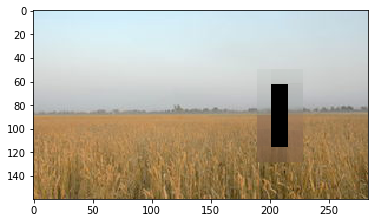


itération 15


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


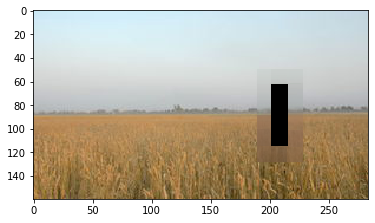


itération 16


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


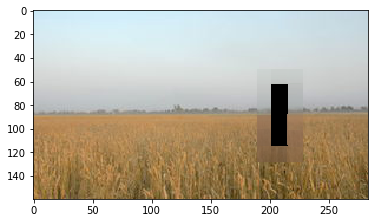


itération 17


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


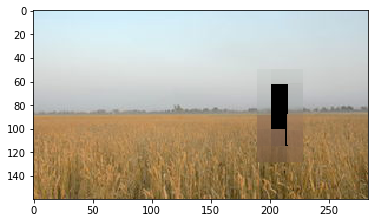


itération 18


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


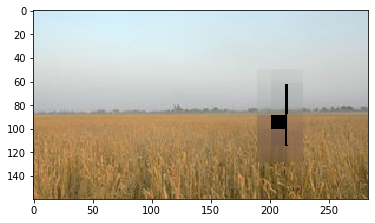


itération 19


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


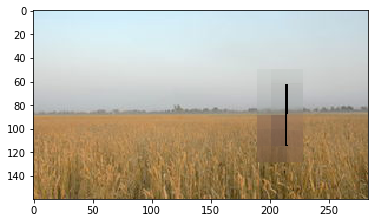


itération 20


C:\Users\33658\Anaconda3\lib\site-packages\ipykernel_launcher.py:218: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


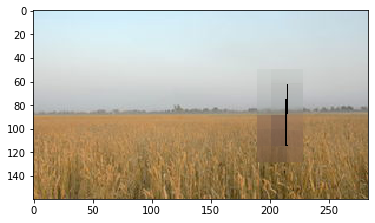


itération 21


In [ ]:
# Executer la cellule pour lancer la reconstitution


# Lecture de l'image
filename = "personne_champs.jpg"
p = read_im(filename)
plt.figure()
plt.imshow(mcolors.hsv_to_rgb(p))
plt.show()

# Selection de la zone à restaurer
#img, border, conf = delete_rect(p,125,170,150,100) #Voilier
#img, border, conf = delete_rect(p,100,70,50,50) #Oiseaux
#img, border, conf = delete_rect(p,100,200,100,90) #Arbre
img, border, conf = delete_rect(p,90,210,80,40) #personne champs

plt.figure()
plt.imshow(mcolors.hsv_to_rgb(img))
plt.show()

# Hyper-parametres

h = 27 #patch length
step = 1 # Pas de construction du dictionnaire
max_iterations = 100000 #iterations du LASSO
a = 0.004

# Creation du dictionnaire de patch

all_patchs = get_all_patchs(h, img, step)
print(f"num of patchs of length {h}: {len(all_patchs)}\n--------------------------------")
dict_patchs, noised_patchs = get_dict(h,img, step)
print(f"num of patchs in the dict: {len(dict_patchs)}\nnum of noised patchs: {len(noised_patchs)}")

#Classifier
clf = linear_model.Lasso(alpha=a, max_iter = max_iterations, normalize = False, positive = False, warm_start = True)

i = 0

# Tant qu'il y a des pixels à restaurer
while len(np.where(img == -100)[0]) != 0:
    print(f"\nitération {i}")
    # On calcul les priorités des pixels sur la bordure et on retourne le pixel prioritaire
    #import ipdb;ipdb.set_trace()
    pixel, conf = priorities(border, conf, h, img)
    
    # On recupère le patch du pixel prioritaire
    patch = get_patch(pixel[0],pixel[1],h,img)
    patch_bound, patch_ind = get_patch_boundaries(pixel[0],pixel[1],h)
    
    # On calcule les coefficients de reconstitution du patch
    coeffs = aprox_patch(conv_patch(patch), dict_patchs,clf)
    new_patch = np.clip(reconstruc_patch(conv_patch(patch), coeffs, dict_patchs),0,1)
    
    
    # On crée une nouvelle image avec le nouveau patch reconstitué
    new_img = copy.deepcopy(img)
    new_img[patch_ind[0], patch_ind[1]] = new_patch.reshape(patch.shape[0]**2,3)
    
    # On met à jour la frontière de la zone à restaurer
    border = update_bound(img, new_img, border, pixel[0], pixel[1], h)
    border = border.T
    
    # On met à jour l'image
    img = copy.deepcopy(new_img)
    
    plt.figure()
    plt.imshow(mcolors.hsv_to_rgb(img))
    plt.show()
    
    i+=1
# Affichage de l'image restaurer
plt.imshow(mcolors.hsv_to_rgb(img))